# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane FInding** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Importing Packages

In [24]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# displaying the images on the jupyter notebook
%matplotlib inline 


## Original image

In this project we will apply a series of transformation to the image, we will therefore start by displaying the original image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


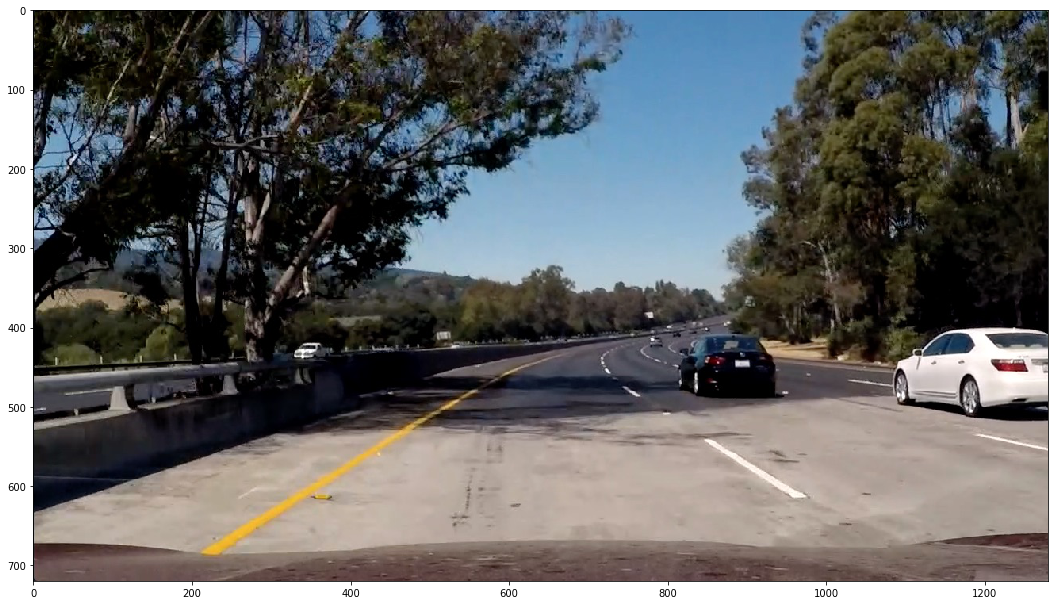

In [25]:
#reading in an image
original_image = mpimg.imread('test_images/test5.jpg')

print('This image is:', type(original_image), 'with dimensions:', original_image.shape)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(original_image)

## Camera calibration

In the follwing cells we will define an undistort function. This function will take a distorted image and output an undistorted image. It is of course assumed that the image you feed into this function is taken from the same camera that took the chessboard images. 
In order to undistord the image we will take different images of a chessboard from different angles and distances. Then, we will apply the cv2.findChessboardCorners function to get the position of the image points. To these image point we will associate its coordinates in the chessboard coordiante system. Using these points we will be able to invoke the cv2.calibrateCamera to get the camera's distorsion matrix. 
we will therefore be able to call the cv2.undistord function to undistord an image taken by the camera


In [26]:
import glob
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_shape = img.shape[::-1]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


Is our calibration successfull ?

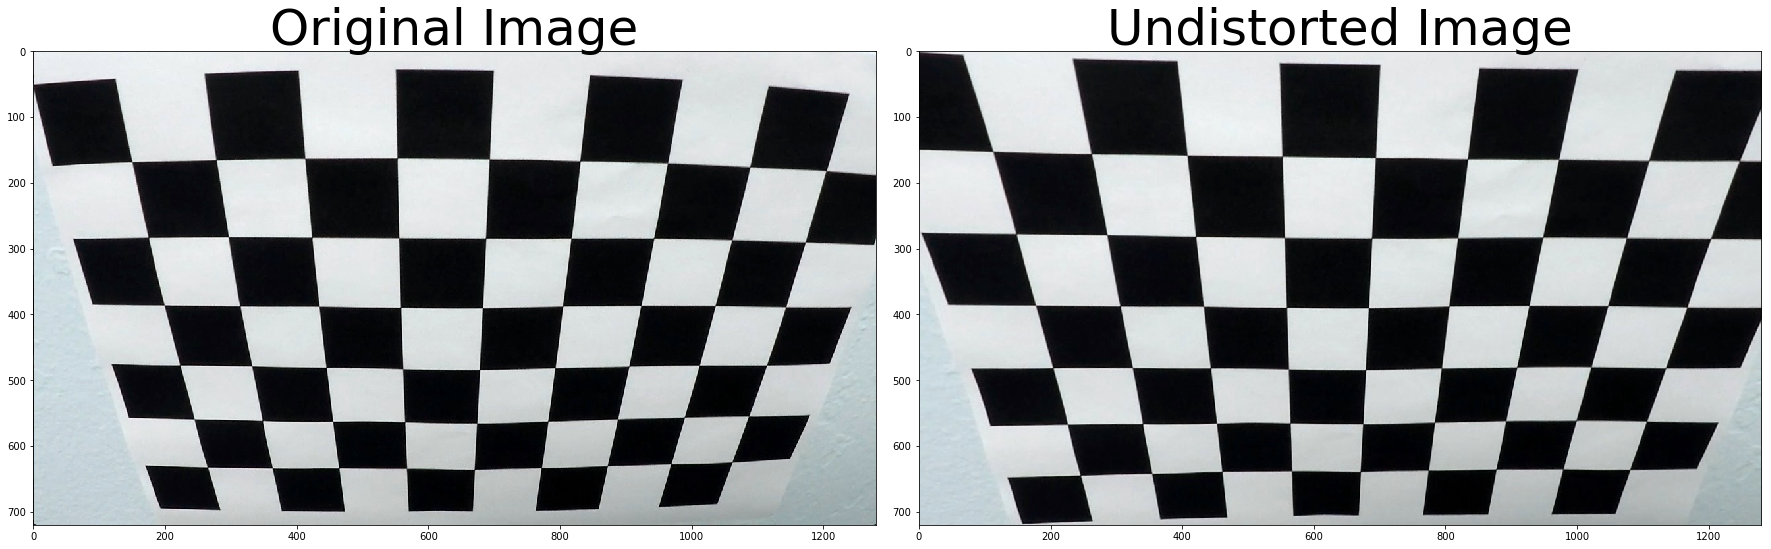

In [27]:
%matplotlib inline

chessboard_distorded = cv2.imread('./camera_cal/calibration2.jpg')
chessboard_undistorded = undistort(chessboard_distorded)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboard_distorded)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(chessboard_undistorded)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Let us now undistort the road image

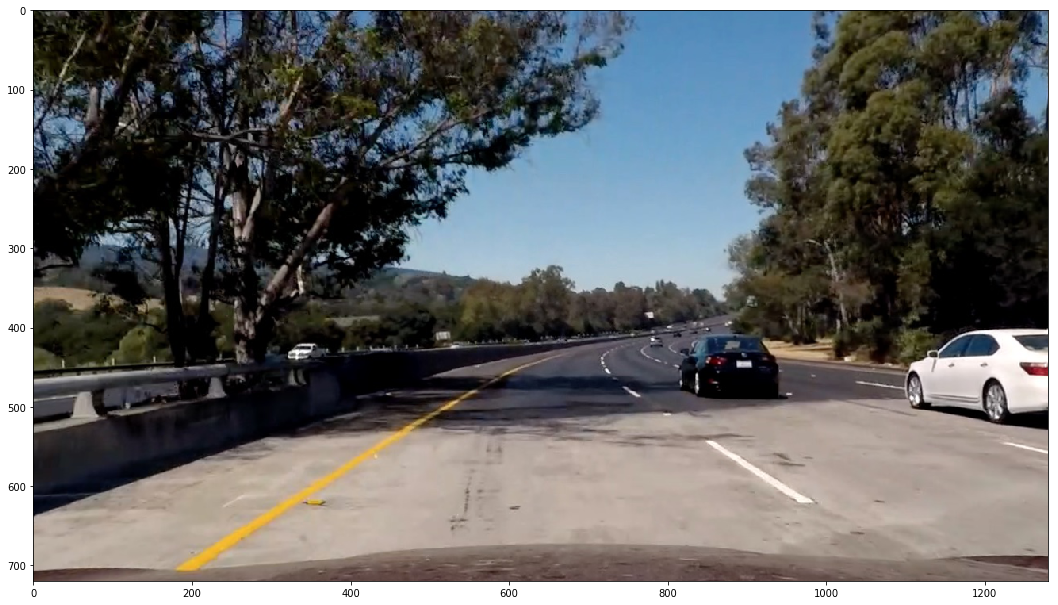

In [28]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
undistorted_image = undistort(original_image)
plt.imshow(undistorted_image)

we can see that some part of the distorted parts of the image have been cropped (top and bottom right corners) because they were distorted


## Binary image

We can now undistort the images coming from our camera. In this section we will take these undistorted images and
output a binary images containing the lines on the road.
We will use 2 different techniques to achieve this:
   1. The RGB color model is not the most convenient to use for filtering because it doesn't allow us to simply select the different variations of a color, HLS color model is better suited for this. The first step is therefore to convert the image's RGB colors to HLS colors and apply to it a color filter (treshold over the S value). We will use the S channel and apply to it the filtering. Indeed, the S channel is better suited for this color filtering because the concrete is greyish while the lines are colorful (high saturation)
   2. In order to select the white lanes from this image, we will have to use to sobel operator. Indeed, the sobel operator allows us to compute the derivative of a gray image according to the x and y axis. We will then compute thanks to these values the magnitude and angle vector of the derivative vector for each pixel . We will then apply a filter to the pixels of the image according to the magnitude, angle, value of the sobel according the x and y axes. Because shadow lines are mistakenly taken lanes we will use a mask and discard the rest of the image but a small polygon centered on the road

### Using colors for filtering

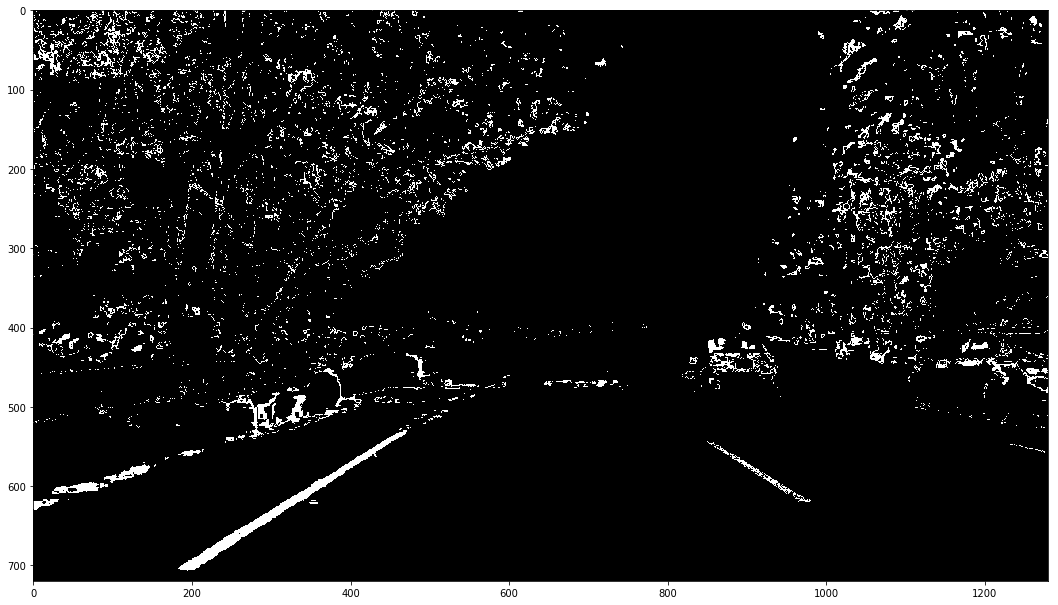

In [29]:
def get_color_mask(undistorded_img):
    hls_image = cv2.cvtColor(undistorded_img, cv2.COLOR_RGB2HLS)
    S = hls_image[:,:,2]
    thresh = (150, 240)
    color_mask = np.zeros_like(S)
    color_mask[(S > thresh[0]) & (S <= thresh[1])] = 1
    return color_mask

color_mask = get_color_mask(undistorted_image)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(color_mask, cmap='gray')


### Using The sobel operator for filtering

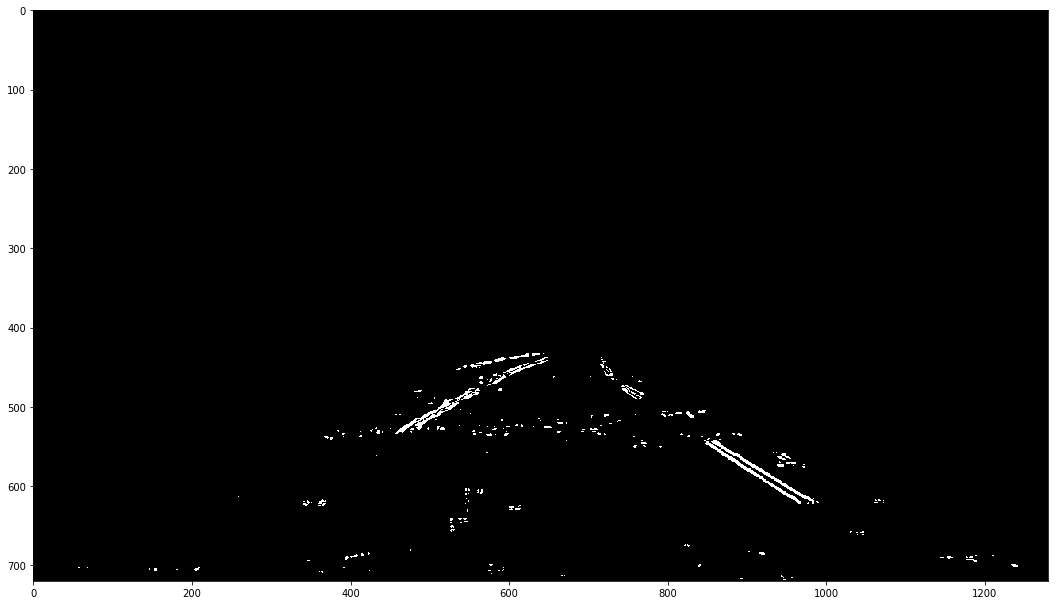

In [30]:
# the input images of these functions should be gray images

def abs_sobel_thresh(gray, axis='x', sobel_kernel=3, thresh_min=0, thresh_max = 255):
    
    # computing the sobel gradiant    
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif axis == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else :
        raise ValueError("wrong axis value, chose between x or y")
    
    # Take the absolute value of the derivative or gradient
    # we use the basolute value because we don't care about the direction   
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
      
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return mask

def mag_thresh(gray, sobel_kernel=3, thresh_min=0, thresh_max=255):
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Computing the magnitude     
    magnitude = np.sqrt(np.add(np.square(sobel_x), np.square(sobel_y)))
    
    # scaling the magnitude
    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    
    # Create mask
    mask = np.zeros_like(scaled_magnitude)
    mask[(scaled_magnitude >= thresh_min) & (scaled_magnitude <= thresh_max)] = 1

    return mask

def dir_threshold(gray, sobel_kernel=3, angle_min=0, angle_max=np.pi/2):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a mask
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    mask =  np.zeros_like(absgraddir)
    mask[(absgraddir >= angle_min) & (absgraddir <= angle_max)] = 1

    # Return the binary image
    return mask

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 1)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_gradiant_mask(undistorded_img):
    gray = cv2.cvtColor(undistorded_img, cv2.COLOR_RGB2GRAY)

    # Sobel kernel size
    ksize = 9 # a larger odd number to smoothes gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, axis='x', sobel_kernel=ksize, thresh_min=10, thresh_max=100)
    grady = abs_sobel_thresh(gray, axis='y', sobel_kernel=ksize, thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh_min=30, thresh_max=100)
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, angle_min=np.pi/8, angle_max= np.pi - np.pi/8)

    # gradiant mask
    gradiant_mask = np.zeros_like(dir_binary)
    gradiant_mask[(gradx == 1) & (mag_binary == 1) & (dir_binary == 1) ] = 1
    ysize = undistorded_img.shape[0]
    xsize = undistorded_img.shape[1]
    vertices = np.array([[(0,ysize),(xsize*.45, ysize*.6), (xsize*.55, ysize*.6), (xsize,ysize)]], dtype=np.int32)
    masked_image = region_of_interest(gradiant_mask,vertices)
    return masked_image

gradiant_mask = get_gradiant_mask(undistorted_image)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(gradiant_mask, cmap='gray')
    

## Combining both masks

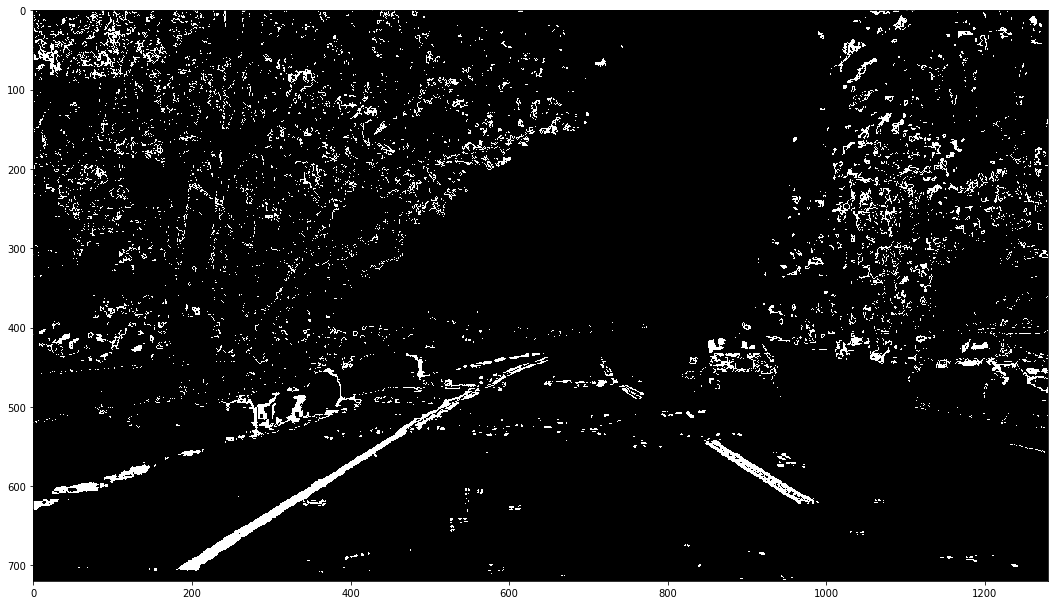

In [31]:
def get_binary_image(undistorded_img):
    gradiant_mask = get_gradiant_mask(undistorded_img)
    color_mask = get_color_mask(undistorded_img)
    overall_mask = np.zeros_like(gradiant_mask)
    overall_mask[(gradiant_mask == 1)|(color_mask == 1)] = 1
    return overall_mask


overall_mask = get_binary_image(undistorted_image)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(overall_mask, cmap='gray')

## Perspective image


We will now use an image where the lines are vertical to get good points for the perspective transform.
Then, we will use the cv2.warpPerspective to obtain a perspective transform of the road

(720, 1280, 3)


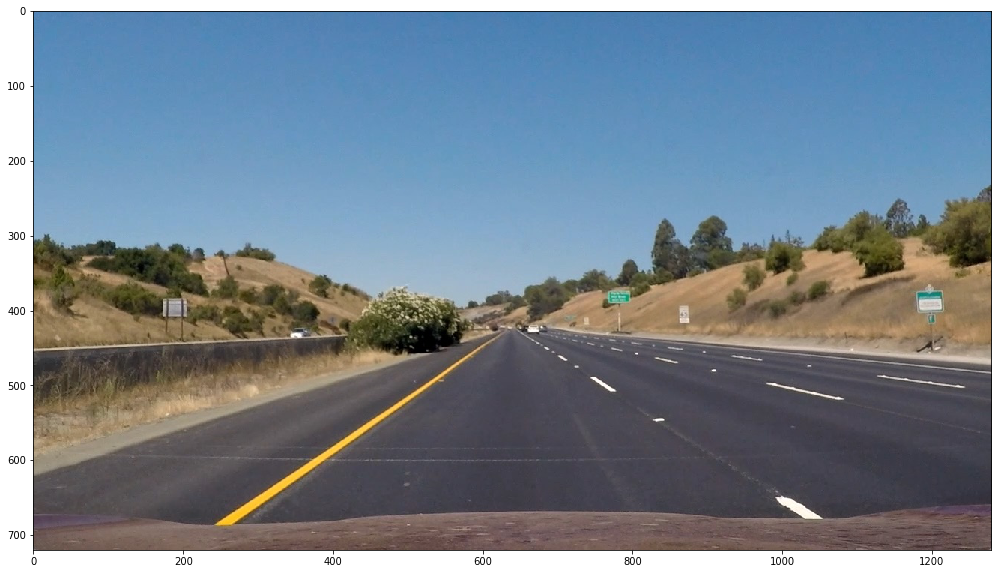

In [33]:
# Using an image with straight line to adjust the perspective transform function

%matplotlib qt

original_image = mpimg.imread('./test_images/straight_lines1.jpg')
print(original_image.shape)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(original_image)

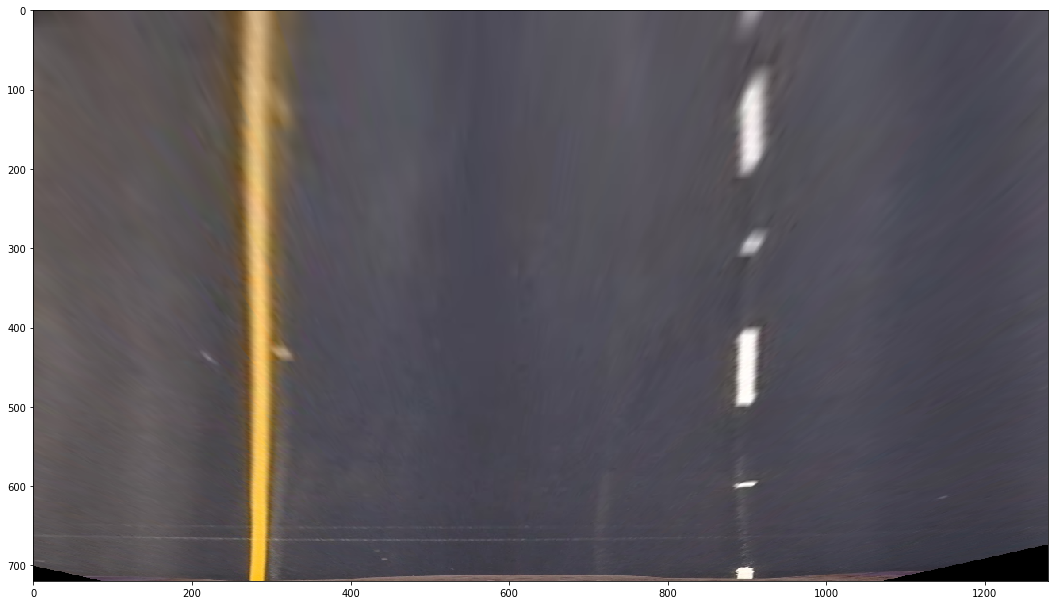

In [34]:
%matplotlib inline

def perspective_transform(img):
    src = np.float32([[254,687], [588,456], [693,456], [1060,687]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[284,720], [284,0], [900,0], [900,720]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Given src and dst points, calculate the inverse of the perspective, we will use it later 
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, M, (1280,720)), Minv

straight_lines, Minv = perspective_transform(original_image)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(straight_lines)

Let us do the same for the mask we computed

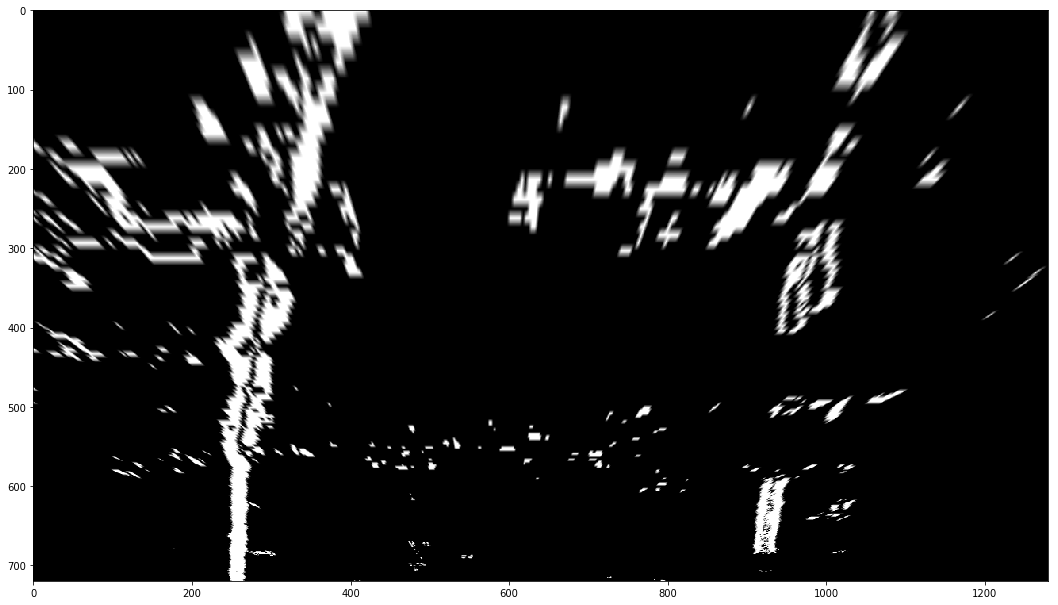

In [35]:
mask_in_perspective, _ = perspective_transform(overall_mask)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(mask_in_perspective, cmap='gray')


## Identification of the pixels that constitute the lines

Now that we have a perspective transform of a binary image, we need to identify which pixels belong to which line.
At first we will define a sliding window search function that will identify the pixels that constitute the lines, then we will look for the pixels constituting the lines assuming we have 2 polynoms that represent x = f(y) for each lines

### Finding lines thanks to the sliding window function

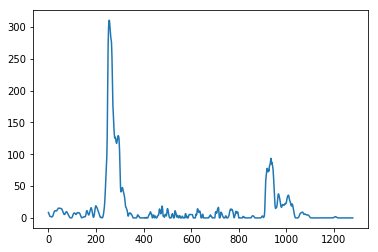

In [36]:
#  WE start by identifying the start of the lines
#  indeed the first sliding window will be the x's at which we reach the max

histogram = np.sum(mask_in_perspective[mask_in_perspective.shape[0]//2:,:], axis=0)
plt.plot(histogram)

We can therefore clearly identify the start of of each line. The right line is less "intense" than the right one because it is not a continous line

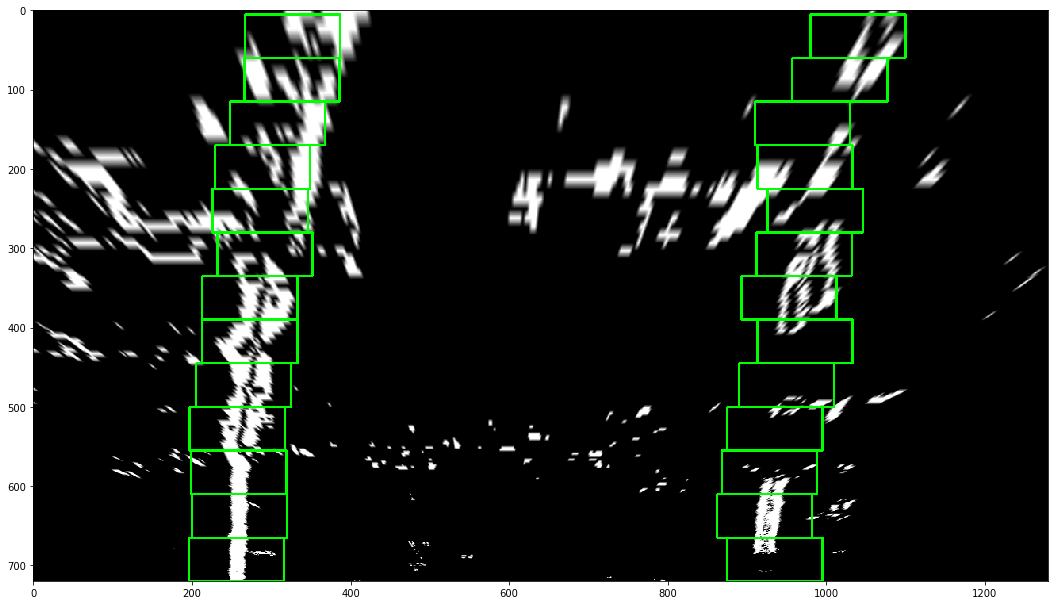

In [37]:
binary_warped = mask_in_perspective

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(mask_in_perspective[mask_in_perspective.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.uint8(255*mask_in_perspective/np.max(mask_in_perspective))
out_img = np.dstack((out_img, out_img, out_img))

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 13

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 60

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(out_img)

(720, 0)

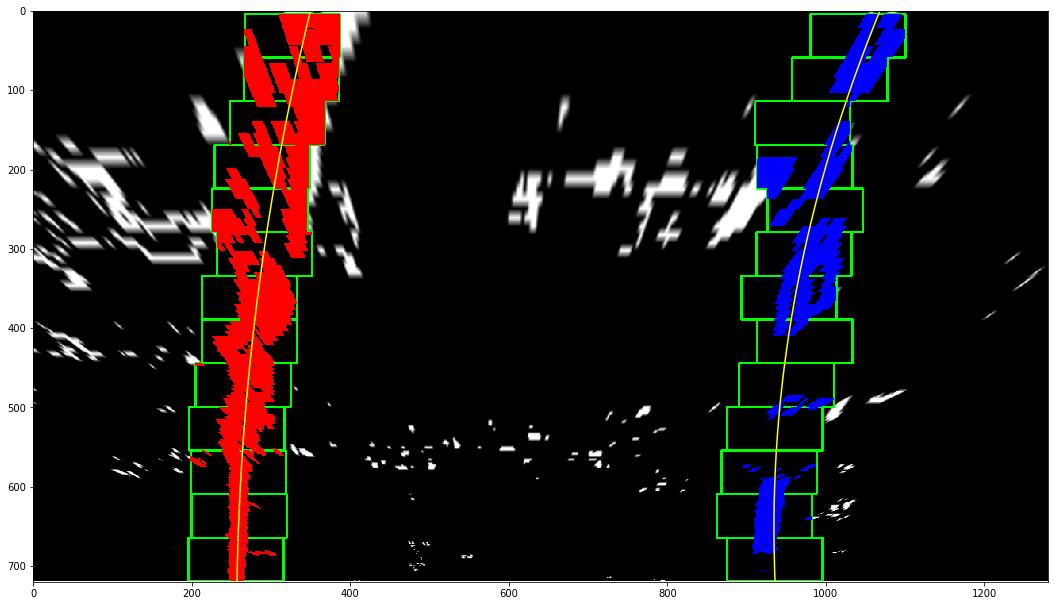

In [38]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Assuming we have x = f(y)  for each line

Since we have now a function representing the line we can use this information the next frame, let us suppose we have now another image ( the one that follows the previous one ) and let us see the pixels we will take into account.
Of course this supposition holds because the images we exctract from the camera are regularly and closely spaced


In [39]:
# assuming we have aother image called "binary_warped" that follows our previous image
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 60
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

Let us visualise the pixels that we have taken into account

(720, 0)

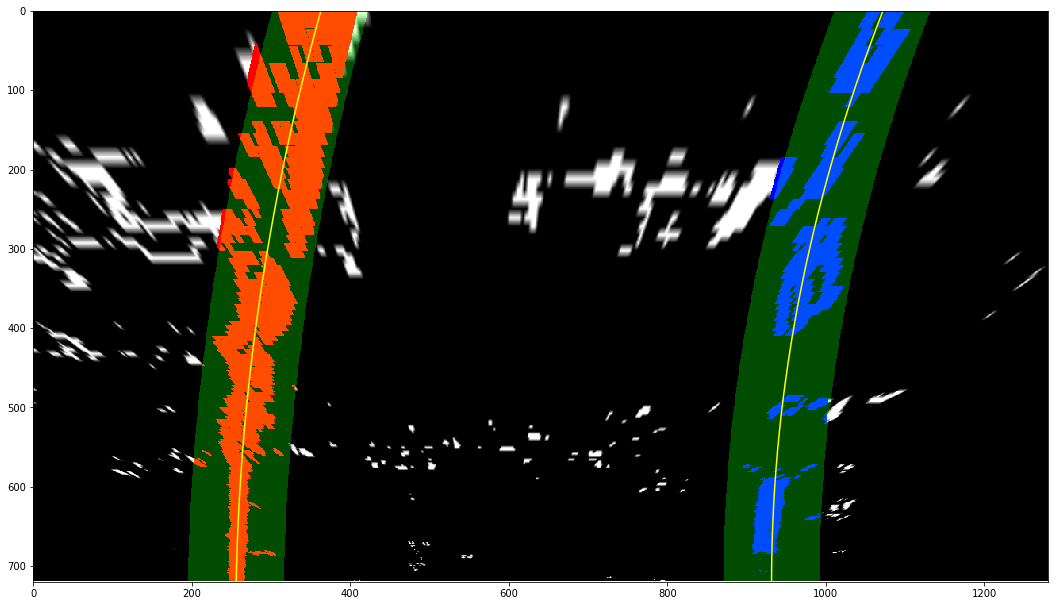

In [40]:
# Create an image to draw on and an image to show the selection window
out_img = np.uint8(255*mask_in_perspective/np.max(mask_in_perspective))
out_img = np.dstack((out_img, out_img, out_img))

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Let's build the get_line_pixels function

Let us merge the work we did before, we will get the following function, in case the polynoms represented the left and right lanes are provided we will use the second method. Otherwise we will use the first one

In [41]:
def get_line_pixels(binary_warped, left_fit=None, right_fit=None):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin  or curve +/- margin
    window_margin = 70
    curve_margin = 50
    
    if left_fit is None or right_fit is None:
    
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result

        out_img = np.uint8(255*binary_warped/np.max(binary_warped))
        out_img = np.dstack((out_img, out_img, out_img))

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 13

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - window_margin
            win_xleft_high = leftx_current + window_margin
            win_xright_low = rightx_current - window_margin
            win_xright_high = rightx_current + window_margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
    else: 
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - curve_margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + curve_margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - curve_margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + curve_margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_polynomials(leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

### Let us check that our function works properly

(720, 0)

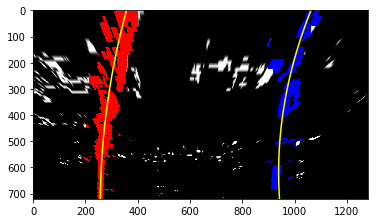

In [42]:
leftx, lefty, rightx, righty = get_line_pixels(mask_in_perspective)

# Fit a second order polynomial to each
left_fit, right_fit = fit_polynomials(leftx, lefty, rightx, righty)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# New out image
out_img = np.uint8(255*mask_in_perspective/np.max(mask_in_perspective))
out_img = np.dstack((out_img, out_img, out_img))

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

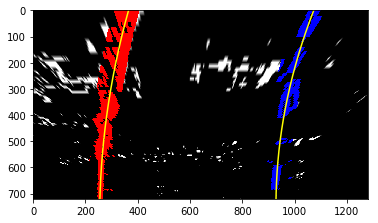

In [43]:
leftx, lefty, rightx, righty = get_line_pixels(mask_in_perspective, left_fit, right_fit)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# New out image
out_img = np.uint8(255*mask_in_perspective/np.max(mask_in_perspective))
out_img = np.dstack((out_img, out_img, out_img))

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring the curvature and the deviation of the midpoint of the lane

We have now the the x = f(y) function, we can now, after translating this function from the pixels space to the real (metres), compute the curvature of the road ( given by the formula )

In [62]:
def compute_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

def compute_deviation(leftx, lefty, rightx, righty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
       
    camera_position = (1280/2)
    x_start_left = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    x_start_right = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    center_of_road = (x_start_left + x_start_right) / 2
    deviation = abs(center_of_road - camera_position)*xm_per_pix
    return deviation

a,b  = compute_curvature(leftx, lefty, rightx, righty)
c = compute_deviation(leftx, lefty, rightx, righty)

print(a, 'm', b, 'm', c, 'm')

935.481034858 m 632.564790506 m 0.252368949767 m


We can see the radius of curbature is at the same scale as the one given in the Udacity course. There is a 300m difference between both lines, it's not that much so it seems to be good enough

### Drawing the lines on the undistorted image

Let us now draw the lines on the original and undistorted image

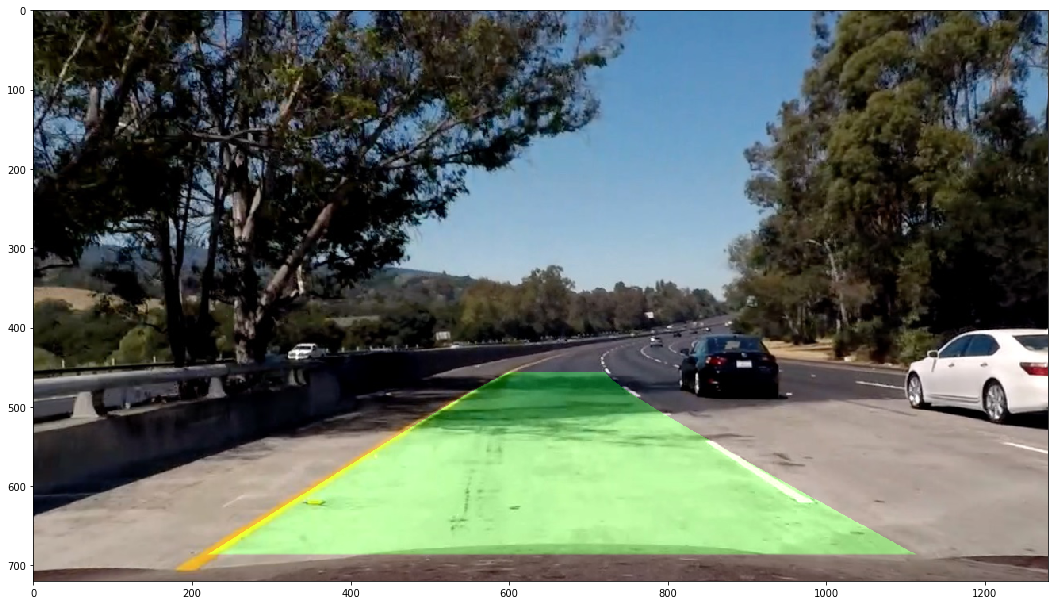

In [66]:
def draw_lines(undistorted_image, Minv, warped_binary_image, left_fit, right_fit):

    ploty = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp = np.uint8(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    return result

leftx, lefty, rightx, righty = get_line_pixels(mask_in_perspective)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
result = draw_lines(undistorted_image, Minv, mask_in_perspective, left_fit, right_fit)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(result)

### process image function and using it on a video


Let us now draw the lines on the original and undistorted image. In case the curvature radius of the a line is inferior to 600m  we will use the previous polynoms. We can afford to do this because badly identified frames are pretty rare with our implementation. In case of a harder circuit we will need to implement a recovery system that will recompure the polynoms using the sliding windows

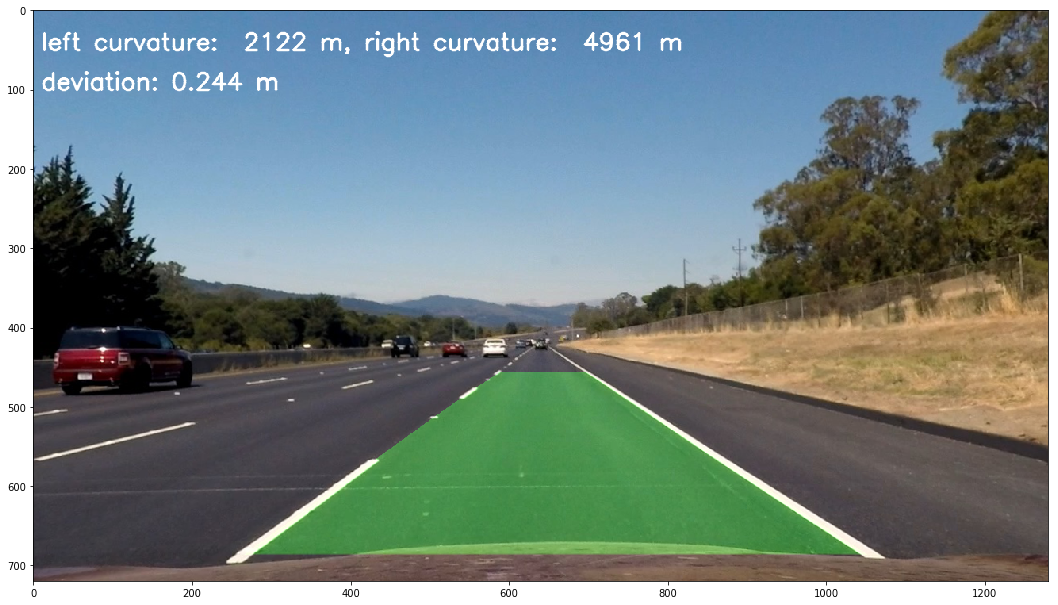

In [82]:
left_fit=None
right_fit=None
previous_left = None
previous_right = None
previous_left_curverad = None
previous_right_curverad = None

def process_image(image):
    
    global left_fit
    global right_fit
    global previous_left
    global previous_right
    global previous_left_curverad
    global previous_right_curverad

    initial_image = np.copy(image)
    
    undistorted = undistort(initial_image)
    
    binary_image = get_binary_image(undistorted)
    
    binary_warped, Minv = perspective_transform(binary_image)
    
    leftx, lefty, rightx, righty = get_line_pixels(binary_warped, left_fit, right_fit)
    
    left_fit, right_fit = fit_polynomials(leftx, lefty, rightx, righty)
    
    left_curverad, right_curverad = compute_curvature(leftx, lefty, rightx, righty)
    
    deviation = compute_deviation(leftx, lefty, rightx, righty)
    
    if left_curverad < 600 and previous_left_curverad is not None:
        left_curverad = previous_left_curverad
        left_fit = previous_left
    
    if right_curverad < 500 and previous_right_curverad is not None:
        right_curverad = previous_right_curverad
        right_fit = previous_right
        
    result = draw_lines(undistorted, Minv, binary_warped, left_fit, right_fit)
    
    curvature_text = "left curvature: {0: 0.0f} m, right curvature: {1: 0.0f} m".format(left_curverad, right_curverad)
    cv2.putText(result,curvature_text,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    deviation_text = "deviation: {0:0.3f} m".format(deviation)
    cv2.putText(result,deviation_text,(10,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    previous_left = left_fit
    previous_left_curverad = left_curverad
    previous_right = right_fit
    previous_right_curverad  = right_curverad
    
    return result


original_image = mpimg.imread('test_images/straight_lines2.jpg')
result = process_image(original_image)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(result)

## Test on Videos

We can test now our solution on the provided video

In [68]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [83]:
white_output = './project_video_result.mp4'

# clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
 
#Clearing my global variable before the run of every video
left_fit=None
right_fit=None
previous_left = None
previous_right = None
previous_left_curverad = None
previous_right_curverad = None


clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|█████████▉| 1260/1261 [05:32<00:00,  4.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

CPU times: user 5min 11s, sys: 58.5 s, total: 6min 10s
Wall time: 5min 33s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Conclusion and discution

In this project we built a pipeline to detect lanes. This solution is better than the first project in many points.
This implementation is however not perfect and several improvements can be made :
1. Currently if the radius of curvature is less than 600 m, we discard the lane measurement and use the previous one. This fallback works well in our case because bad frames are not that common so that our algorithm can get quickly back on his feet.
2. Shadows are a real nightmare for our pipeline. Indeed, when applying the sobel transform to our image, shadow lanes are detected as lanes. To prevent this effect I have applied after the sobel operator a mask that turns everything outside the region of interest to 0. I really wonder how our pipeline will behave in case the road crosses a forest with high trees generating discontinued shadows
3. Neighboring cars can easily perturb our pipeline, particularly if they have some shiny color. Indeed the detection of the start of the line using the histogram will be wrong
4. In the current implementation, we only use the sliding window at the beginning. In case a car gets in our way at that moment, it will take a lot of time to our system to recover because we will not use the sliding window but keep on using the previous fitted polynomials and look at the neighboring pixels